In [1]:
import pandas as pd
from astropy.io import fits
from myfit.voigt.fit import Ilam
from scipy.optimize import curve_fit
%pylab inline

Welcome to use myfit!
version=0.1
Populating the interactive namespace from numpy and matplotlib


In [2]:
def compute_N(name,p0=[0,30,30,2e14,2e14]):
    
    s1 = fits.open('HIRES/' + name + '_f.fits')
    s2 = fits.open('HIRES/' + name + '_e.fits')
    
    flux = s1[0].data
    noise = s2[0].data
    c0 = s1[0].header['CRVAL1']
    c1 = s1[0].header['CDELT1']

    wavelength = 10.**(c0 + c1 * np.arange(1,len(flux)+1))
    data = pd.read_csv('ESI\z data.csv')
    idx = data['Name'] == name
    z = data['z_abs'][idx]
    z = float(z)
    restframe = wavelength/(1+z)

    center = (1548.1950+1550.77)/2
    idx2 = np.where((restframe-center<=3)&(restframe-center>=-3))

    popt,pcov = curve_fit(Ilam,restframe[idx2],flux[idx2],
                          sigma = noise[idx2],p0=p0,
                          bounds=([-5, 0,0, 1e12,1e12], [5, 50,50, 2e15,2e15]))

    return popt,restframe[idx2],flux[idx2],z

In [3]:
names = ['FJ0812+32','J0900+42','Q1021+30','Q1209+0919','Q1337+11','Q1425+60','J2340-00','Q2342+34']
N_XJP = {'FJ0812+32':['=13.95', '=13.95'],'J0900+42':['=13.60','=nan'],
     'Q1021+30':['=14.01','=13.95'],'Q1209+0919':['>14.97','=15.20'],
    'Q1337+11':['=13.36','=13.52'],'Q1425+60':['>14.79','=14.73'],
    'J2340-00':['=14.00','=14.06'],'Q2342+34':['>14.43','=14.46']}

In [4]:
popt,restframe,flux,z = [],[],[],[]
p0  = [0.5,30,30,1e14,2e14]
for name in names:
    result = compute_N(name,p0)
    popt.append(result[0])
    restframe.append(result[1])
    flux.append(result[2])
    z.append(result[3])

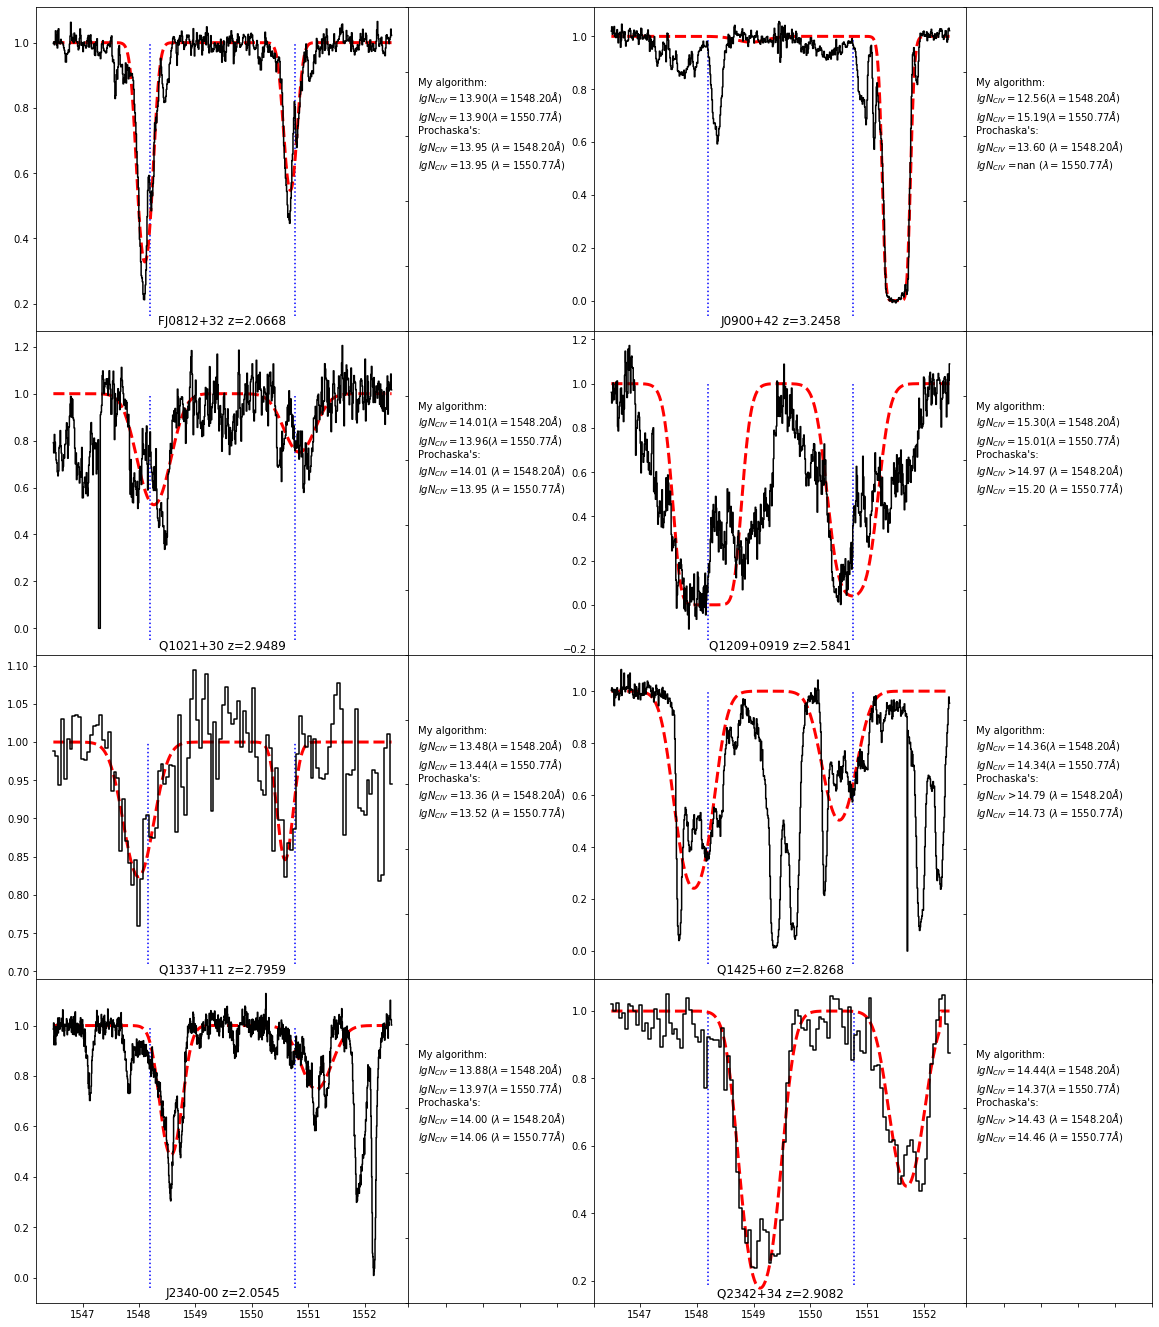

In [5]:
fig = figure(figsize=(20,18))

for i in range(len(names)):
    lamfit = linspace(min(restframe[i]),max(restframe[i]),500)
#     print(i)
    if i%2==0:
        ax = subplot2grid((4, 6), (i//2, 0), rowspan=1, colspan=2)
        ax2 = subplot2grid((4, 6), (i//2, 2), rowspan=1, colspan=1)
    else:
        ax = subplot2grid((4, 6), (i//2, 3), rowspan=1, colspan=2)
        ax2 = subplot2grid((4, 6), (i//2, 5), rowspan=1, colspan=1)

    setp(ax2.get_xticklabels(), visible=False)
    setp(ax2.get_yticklabels(), visible=False)
    subplots_adjust(bottom=0, top=1, hspace=0)
    subplots_adjust(wspace=0)
    
    ax2.text(0.05,0.5,'My algorithm:'+'\n'
             +r'$lgN_{CIV} = %.2f (\lambda = 1548.20 \AA)$'%(log10(popt[i][3]))+'\n'
             +r'$lgN_{CIV} = %.2f (\lambda = 1550.77 \AA)$'%(log10(popt[i][4]))+'\n'
             +'Prochaska\'s:'+'\n'+r'$lgN_{CIV}$ %s ($\lambda = 1548.20 \AA$)'%(N_XJP[names[i]][0])
             +'\n'+r'$lgN_{CIV}$ %s ($\lambda = 1550.77 \AA$)'%(N_XJP[names[i]][1])
            )
    ax.set_title(names[i]+' z='+str(z[i]),y=0)
    ax.vlines([1548.1950,1550.77],min(flux[i])-0.05,1,color='blue',linestyle=':')
    ax.plot(lamfit,Ilam(lamfit,*popt[i]),'r--',linewidth = 3)
    ax.plot(restframe[i],flux[i],drawstyle='steps-mid',color='k')
    
savefig('contrast.png',bbox_inches = 'tight')